# Imports and Helpers

Imports and variables for presentation

In [ ]:
!pip install langchain openai transformers typing python-dotenv google-search-results splunk-sdk tiktoken PyPDF2 faiss-cpu transformers torch onnxruntime==1.12.1 

In [ ]:
import os
import openai
import json
from dotenv import load_dotenv
from typing import Literal, Dict, Optional, Any, List, Type
from bs4 import BeautifulSoup
import requests

import os
import requests
import json
import time
import random
import re
import string
from transformers import RobertaTokenizer, AutoTokenizer

from transformers import (
    AutoConfig,
    MT5Config,
    T5ForConditionalGeneration,
)
from transformers.modeling_outputs import (
    Seq2SeqLMOutput,
    BaseModelOutput,
)
import torch
import functools
import operator

from onnxruntime import (
    GraphOptimizationLevel,
    InferenceSession,
    SessionOptions,
    ExecutionMode,
)

from langchain.llms import OpenAI
from langchain.chat_models import ChatOpenAI
from langchain import PromptTemplate
from langchain.chains import LLMChain, SimpleSequentialChain, SequentialChain
from langchain.chains.summarize import load_summarize_chain
from langchain.agents import initialize_agent, Tool, load_tools
from langchain.agents import AgentType
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.tools import BaseTool
from pydantic import BaseModel, Field
from langchain.schema import SystemMessage
from langchain.prompts import MessagesPlaceholder
from langchain.memory import ConversationSummaryBufferMemory
from langchain.agents import ZeroShotAgent, Tool, AgentExecutor
from langchain.embeddings import OpenAIEmbeddings
from PyPDF2 import PdfReader
from langchain.text_splitter import CharacterTextSplitter
from langchain.document_loaders import TextLoader
from langchain.vectorstores import FAISS
from langchain.chains import RetrievalQA

import xml.etree.ElementTree as ET

import splunklib.client as client
import splunklib.results as results
from splunklib.binding import HTTPError
import pandas as pd

import urllib3
urllib3.disable_warnings()

In [ ]:
from dotenv import load_dotenv

load_dotenv()
serper_api_key = os.getenv("SERP_API_KEY")
openai_api_key = os.getenv("OPENAI_API_KEY")
browserless_api_key = os.getenv('BROWSERLESS_API_KEY')
splunk_url = os.getenv('SPLUNK_URL')
splunk_username = os.getenv('SPLUNK_USERNAME')
splunk_password = os.getenv('SPLUNK_PASSWORD')

In [ ]:
openai_api_key = os.getenv('OPENAI_API_KEY')
openai.api_key=openai_api_key

serpapi_api_key = os.getenv('SERPAPI_API_KEY')

serper_api_key = os.getenv('SERPER_API_KEY')

browserless_api_key = os.getenv('BROWSERLESS_API_KEY')

os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_PROJECT"] = "SplunkGPT"
os.environ["LANGCHAIN_API_KEY"] = "ls__"

# SplunkGPT Cookbook
**Goal**: Provide an introductory understanding of the components and use cases of utilizing and expanding the capabilties of an LLM like GPT via prompt engineering, LangChain, and developing agents.

## What's an LLM?
A large language model (LLM) is a type of artificial intelligence (AI) algorithm that uses deep learning techniques and massively large data sets to understand, summarize, generate and predict new content. An LLM is not ChatGPT. ChatGPT is a trained model by OpenAI that uses Reinforcement Learning from Human Feedback. Other LLMs exist such as LLama, Flan, Bert, etc...  

### What's GPT?
OpenAI has developed GPT (generative pre-trained transformer) models have been trained to understand natural language and code. GPTs provide text outputs in response to their inputs. The inputs to GPTs are also referred to as "prompts". Designing a prompt is essentially how you "program" a GPT model, usually by providing instructions or some examples of how to successfully complete a task. GPTs can be used across a great variety of tasks including content or code generation, summarization, conversation, creative writing, and more.

# Limitations of LLM

In [ ]:
# insert code here
user_prompt_1 = "Write a splunk query that lists users with failed logon attempts"
response_1 = openai.Completion.create(
            model="davinci",
            prompt=user_prompt_1,
            temperature=1,
        )

In [ ]:
#print(response_1)
print("Davinci Model Response: \n")
print("\"\"\"")
print(response_1.choices[0].text)
print("\"\"\"")

### General process of tuning a model
https://platform.openai.com/docs/guides/fine-tuning/preparing-your-dataset

#### Step 1: Gather the data

Scraped ~500 queries from Splunk Community Forum, Splunk Online Documentation, Splunkbase, GitHub, GoSplunk SPL Database

#### Step 2: Format the Data
```
{"prompt": "<prompt text>", "completion": "<ideal generated text>"}
```
Example:
```
  {
    "prompt": "Write a Splunk query that retrieves and analyzes failed login attempts for the Administrator and Guest accounts with more than 5 failed logon attempts.",
    "completion": "index=windows LogName=Security EventCode=4625 (Account_Name=administrator OR Account_Name=guest)  | stats count values(Workstation_Name) AS Workstation_Name, Values(Source_Network_Address) AS Source_IP_Address, values(host) AS Host by Account_Name  | where count > 5\" Failed Login Attempts\tindex=yourindex sourcetype=\"\"WinEventLog:Security\"\" EventCode=4625|fillnull value=NULL| eval Account_Name = mvindex(Account_Name,1) | eval Security_ID = mvindex(Security_ID,1) | eval Logon_Type=case(Logon_Type=3,\"\"RPC (not RDP)\"\",Logon_Type=4,\"\"Batch\"\",Logon_Type=5,\"\"Service\"\",Logon_Type=7,\"\"Screen Unlock/Session Resume\"\",Logon_Type=10,\"\"Remote Desktop\"\",Logon_Type=11,\"\"Cached\"\",Logon_Type=9,\"\"New Credentials\"\")|stats count(Security_ID) as \"\"Login Events\"\" by Security_ID, Account_Name, Logon_Type, host, _time |sort + Security_ID\""
  }
```

#### Step 3: Validate Format and Tune Model

```
openai tools fine_tunes.prepare_data -f train-data-3.json
openai api fine_tunes.create -t train-data-3_prepared.jsonl -m davinci --suffix "SplunkGPT"
openai api fine_tunes.follow -i <id-provided-from-above>
```

#### Step 4: Use model, analyze results, and reiterate tuning


In [ ]:
user_prompt_2 = "Write a splunk query that lists users with failed logon attempts"
response_2 = openai.Completion.create(
            model="davinci:ft-personal:splunkgpt-2023-07-31-00-58-57",
            prompt=(user_prompt_2),
            temperature=1,
        )

In [ ]:
#print(response_2)
print("Tuned Model Response: \n")
print("\"\"\"")
print(response_2.choices[0].text)
print("\"\"\"")

print("Response we were looking for:")
print("\"\"\"")
print("index=main sourcetype=\"WinEventLog:Security\" EventCode=4625 \n| stats count by Account_Name, src_ip \n| where count > 1")
print("\"\"\"")

# Internal reflection
- Why did it fail?
- We've spent $40 in tuning, should we continue down the path of tuning this model?
- What are our other options?
 - Continue to reiterate our tuning process
 - Use an existing fine tuned model
 - Create an agent

## Splunk AI Predictor Classes

### Download Model

In [ ]:
import requests
import tarfile

def download_and_extract(url, save_path="."):
    # Download the file
    response = requests.get(url, stream=True)
    file_name = url.split("/")[-1]

    with open(file_name, "wb") as file:
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)

    # Extract the file
    with tarfile.open(file_name, 'r:gz') as tar:
        tar.extractall(path=save_path)
    print(f"File {file_name} has been downloaded and extracted.")

download_and_extract("https://download.splunk.com/products/Splunk_AI_Assistant/beta/0.2.3/linux/Splunk_AI_Assistant_0.2.3-d28e4b4.tgz")
script_dir = '/content/Splunk_AI_Assistant/lib/artifacts/'

### Classes

In [ ]:
def get_onnx_runtime_sessions(
    model_paths,
    default: bool = True,
    opt_level: int = 99,
    parallel_exe_mode: bool = True,
    n_threads: int = 0,
    provider=[
        "CPUExecutionProvider",
    ],
) -> InferenceSession:
    """
            Optimizes the model
    Args:
        model_paths (List or Tuple of str) : the path to, in order:
            path_to_encoder (str) : the path of input onnx encoder model.
            path_to_decoder (str) : the path of input onnx decoder model.
            path_to_initial_decoder (str) :  the path of input initial onnx decoder model.
        default : set this to true, ort will choose the best settings for your hardware.
                  (you can test out different settings for better results.)
        opt_level (int) : sess_options.GraphOptimizationLevel param if set 1 uses 'ORT_ENABLE_BASIC',
                          2 for 'ORT_ENABLE_EXTENDED' and 99 for 'ORT_ENABLE_ALL',
                          default value is set to 99.
        parallel_exe_mode (bool) :  Sets the execution mode. Default is True (parallel).
        n_threads (int) :  Sets the number of threads used to parallelize the execution within nodes. Default is 0 to let onnxruntime choose
        provider : execution providers list.
    Returns:
        encoder_session : encoder onnx InferenceSession
        decoder_session : decoder onnx InferenceSession
        decoder_sess_init : initial decoder onnx InferenceSession
    """
    path_to_encoder, path_to_decoder, path_to_initial_decoder = model_paths

    if default:

        encoder_sess = InferenceSession(str(path_to_encoder))

        decoder_sess = InferenceSession(str(path_to_decoder))

        decoder_sess_init = InferenceSession(str(path_to_initial_decoder))

    else:

        # Few properties that might have an impact on performances
        options = SessionOptions()

        if opt_level == 1:
            options.graph_optimization_level = GraphOptimizationLevel.ORT_ENABLE_BASIC
        elif opt_level == 2:
            options.graph_optimization_level = (
                GraphOptimizationLevel.ORT_ENABLE_EXTENDED
            )
        else:
            assert opt_level == 99
            options.graph_optimization_level = GraphOptimizationLevel.ORT_ENABLE_ALL

        # set this true for better performance
        if parallel_exe_mode == True:
            options.execution_mode = ExecutionMode.ORT_PARALLEL
        else:
            options.execution_mode = ExecutionMode.ORT_SEQUENTIAL

        options.intra_op_num_threads = n_threads
        # options.inter_op_num_threads = 10

        # options.enable_profiling = True

        encoder_sess = InferenceSession(
            str(path_to_encoder), options, providers=provider
        )

        decoder_sess = InferenceSession(
            str(path_to_decoder), options, providers=provider
        )

        decoder_sess_init = InferenceSession(
            str(path_to_initial_decoder), options, providers=provider
        )

    return encoder_sess, decoder_sess, decoder_sess_init


class T5Encoder(torch.nn.Module):
    def __init__(self, encoder_sess):
        super().__init__()
        self.encoder = encoder_sess
        self.main_input_name = "input_ids"

    def forward(
        self,
        input_ids,
        attention_mask,
        inputs_embeds=None,
        head_mask=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):

        encoder_hidden_state = torch.from_numpy(
            self.encoder.run(
                None,
                {
                    "input_ids": input_ids.cpu().numpy(),
                    "attention_mask": attention_mask.cpu().numpy(),
                },
            )[0]
        )

        return BaseModelOutput(encoder_hidden_state)


class T5DecoderInit(torch.nn.Module):
    def __init__(self, decoder_sess):
        super().__init__()
        self.decoder = decoder_sess

    def forward(self, input_ids, encoder_attention_mask, encoder_hidden_states):

        decoder_outputs = self.decoder.run(
            None,
            {
                "input_ids": input_ids.cpu().numpy(),
                "encoder_attention_mask": encoder_attention_mask.cpu().numpy(),
                "encoder_hidden_states": encoder_hidden_states.cpu().numpy(),
            },
        )

        list_pkv = tuple(torch.from_numpy(x) for x in decoder_outputs[1:])

        out_past_key_values = tuple(
            list_pkv[i : i + 4] for i in range(0, len(list_pkv), 4)
        )

        return torch.from_numpy(decoder_outputs[0]), out_past_key_values


class T5Decoder(torch.nn.Module):
    def __init__(self, decoder_sess):
        super().__init__()
        self.decoder = decoder_sess

    def forward(self, input_ids, attention_mask, encoder_output, past_key_values):

        decoder_inputs = {
            "input_ids": input_ids.cpu().numpy(),
            "encoder_attention_mask": attention_mask.cpu().numpy(),
            "encoder_hidden_states": encoder_output.cpu().numpy(),
        }

        flat_past_key_values = functools.reduce(operator.iconcat, past_key_values, [])

        past_key_values = {
            f"pkv_{i}": pkv.cpu().numpy() for i, pkv in enumerate(flat_past_key_values)
        }

        decoder_outputs = self.decoder.run(None, {**decoder_inputs, **past_key_values})
        # converts each value of the list to tensor from numpy
        list_pkv = tuple(torch.from_numpy(x) for x in decoder_outputs[1:])

        # creates a tuple of tuples of shape 6x4 from the above tuple
        out_past_key_values = tuple(
            list_pkv[i : i + 4] for i in range(0, len(list_pkv), 4)
        )

        return torch.from_numpy(decoder_outputs[0]), out_past_key_values


class OnnxT5(T5ForConditionalGeneration):
    """creates a T5 model using onnx sessions (encode, decoder & init_decoder)"""

    def __init__(self, model_or_model_path, onnx_model_sessions):
        config = AutoConfig.from_pretrained(
            model_or_model_path
        )
        super().__init__(config)

        # monkeypatch to work for MT5
        if (
            isinstance(model_or_model_path, str)
            and "mt5" in model_or_model_path.lower()
        ) or (
            hasattr(model_or_model_path, "name_or_path")
            and "mt5" in model_or_model_path.name_or_path
        ):
            self.model_type = "mt5"
            self.config_class = MT5Config
            self._keys_to_ignore_on_load_missing = [
                r"encoder\.embed_tokens\.weight",
            ]
            self._keys_to_ignore_on_save = [
                r"encoder\.embed_tokens\.weight",
            ]

        assert len(onnx_model_sessions) == 3, "all three models should be given"

        encoder_sess, decoder_sess, decoder_sess_init = onnx_model_sessions

        self.encoder = T5Encoder(encoder_sess)
        self.decoder = T5Decoder(decoder_sess)
        self.decoder_init = T5DecoderInit(decoder_sess_init)

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        decoder_input_ids=None,
        decoder_attention_mask=None,
        head_mask=None,
        decoder_head_mask=None,
        cross_attn_head_mask=None,
        encoder_outputs=None,
        past_key_values=None,
        inputs_embeds=None,
        decoder_inputs_embeds=None,
        labels=None,
        use_cache=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):

        if encoder_outputs is None:
            # Convert encoder inputs in embeddings if needed
            encoder_outputs = self.encoder(
                input_ids=input_ids, attention_mask=attention_mask
            )

        encoder_hidden_states = encoder_outputs[0]

        if past_key_values is not None:
            if decoder_input_ids is not None:
                decoder_input_ids = decoder_input_ids[:, -1:]
            if decoder_inputs_embeds is not None:
                decoder_inputs_embeds = decoder_inputs_embeds[:, -1:]

        if past_key_values is None:

            # runs only for the first time:
            init_onnx_outputs = self.decoder_init(
                decoder_input_ids, attention_mask, encoder_hidden_states
            )

            logits, past_key_values = init_onnx_outputs

        else:

            onnx_outputs = self.decoder(
                decoder_input_ids,
                attention_mask,
                encoder_hidden_states,
                past_key_values,
            )

            logits, past_key_values = onnx_outputs

        return Seq2SeqLMOutput(logits=logits, past_key_values=past_key_values)
class Predictor:
    def __init__(self) -> None:
        model_id = "onnx_t5_small_0615_explain_quantized"
        onnx_model_paths = (
            script_dir
            + f"{model_id}/copilot-encoder.onnx",
            script_dir
            + f"{model_id}/copilot-decoder.onnx",
            script_dir
            + f"{model_id}/copilot-init-decoder.onnx",
        )

        config_path = (
            script_dir + f"{model_id}/config"
        )
        model_sessions = get_onnx_runtime_sessions(onnx_model_paths)
        self.model = OnnxT5(config_path, model_sessions)
        self.tokenizer = AutoTokenizer.from_pretrained(
            script_dir
            + f"{model_id}/tokenizer",
        )

    def predict(self, prompt):
        """
        Make predictions.
        """
        prefix = "<Splunk Instruction>: "
        # Tokenize English description
        batch = self.tokenizer(
            prefix+prompt,
            max_length=512,
            padding="max_length",
            return_tensors="pt",
        )

        # Generate predictions using beam search
        output = self.model.generate(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            num_beams=5,
            num_return_sequences=1,
            repetition_penalty=5.0,
            output_scores=True,
            max_length=512,
            return_dict_in_generate=True,
        )

        # Decode tokenized predictions
        predictions = self.tokenizer.batch_decode(output["sequences"], skip_special_tokens=True)

        # Return results, capping at a maximum of 5 results
        return predictions

# Splunk AI
https://www.splunk.com/en_us/blog/it/building-an-ai-assistant-for-splunk.html

# SPL Gen Deps

In [ ]:
import requests
import tarfile

def download_and_extract(url, save_path="."):
    # Download the file
    response = requests.get(url, stream=True)
    file_name = url.split("/")[-1]

    with open(file_name, "wb") as file:
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)

    # Extract the file
    with tarfile.open(file_name, 'r:gz') as tar:
        tar.extractall(path=save_path)
    print(f"File {file_name} has been downloaded and extracted.")

download_and_extract("https://download.splunk.com/products/Splunk_AI_Assistant/beta/0.2.3/linux/Splunk_AI_Assistant_0.2.3-d28e4b4.tgz")
script_dir = '/content/Splunk_AI_Assistant/lib/artifacts/'

In [ ]:
def get_onnx_runtime_sessions(
    model_paths,
    default: bool = True,
    opt_level: int = 99,
    parallel_exe_mode: bool = True,
    n_threads: int = 0,
    provider=[
        "CPUExecutionProvider", "AzureExecutionProvider"
    ],
) -> InferenceSession:
    """
            Optimizes the model
    Args:
        model_paths (List or Tuple of str) : the path to, in order:
            path_to_encoder (str) : the path of input onnx encoder model.
            path_to_decoder (str) : the path of input onnx decoder model.
            path_to_initial_decoder (str) :  the path of input initial onnx decoder model.
        default : set this to true, ort will choose the best settings for your hardware.
                  (you can test out different settings for better results.)
        opt_level (int) : sess_options.GraphOptimizationLevel param if set 1 uses 'ORT_ENABLE_BASIC',
                          2 for 'ORT_ENABLE_EXTENDED' and 99 for 'ORT_ENABLE_ALL',
                          default value is set to 99.
        parallel_exe_mode (bool) :  Sets the execution mode. Default is True (parallel).
        n_threads (int) :  Sets the number of threads used to parallelize the execution within nodes. Default is 0 to let onnxruntime choose
        provider : execution providers list.
    Returns:
        encoder_session : encoder onnx InferenceSession
        decoder_session : decoder onnx InferenceSession
        decoder_sess_init : initial decoder onnx InferenceSession
    """
    path_to_encoder, path_to_decoder, path_to_initial_decoder = model_paths

    if default:

        encoder_sess = InferenceSession(str(path_to_encoder))

        decoder_sess = InferenceSession(str(path_to_decoder))

        decoder_sess_init = InferenceSession(str(path_to_initial_decoder))

    else:

        # Few properties that might have an impact on performances
        options = SessionOptions()

        if opt_level == 1:
            options.graph_optimization_level = GraphOptimizationLevel.ORT_ENABLE_BASIC
        elif opt_level == 2:
            options.graph_optimization_level = (
                GraphOptimizationLevel.ORT_ENABLE_EXTENDED
            )
        else:
            assert opt_level == 99
            options.graph_optimization_level = GraphOptimizationLevel.ORT_ENABLE_ALL

        # set this true for better performance
        if parallel_exe_mode == True:
            options.execution_mode = ExecutionMode.ORT_PARALLEL
        else:
            options.execution_mode = ExecutionMode.ORT_SEQUENTIAL

        options.intra_op_num_threads = n_threads
        # options.inter_op_num_threads = 10

        # options.enable_profiling = True

        encoder_sess = InferenceSession(
            str(path_to_encoder), options, providers=provider
        )

        decoder_sess = InferenceSession(
            str(path_to_decoder), options, providers=provider
        )

        decoder_sess_init = InferenceSession(
            str(path_to_initial_decoder), options, providers=provider
        )

    return encoder_sess, decoder_sess, decoder_sess_init

In [ ]:
class T5Encoder(torch.nn.Module):
    def __init__(self, encoder_sess):
        super().__init__()
        self.encoder = encoder_sess
        self.main_input_name = "input_ids"

    def forward(
        self,
        input_ids,
        attention_mask,
        inputs_embeds=None,
        head_mask=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):

        encoder_hidden_state = torch.from_numpy(
            self.encoder.run(
                None,
                {
                    "input_ids": input_ids.cpu().numpy(),
                    "attention_mask": attention_mask.cpu().numpy(),
                },
            )[0]
        )

        return BaseModelOutput(encoder_hidden_state)


class T5DecoderInit(torch.nn.Module):
    def __init__(self, decoder_sess):
        super().__init__()
        self.decoder = decoder_sess

    def forward(self, input_ids, encoder_attention_mask, encoder_hidden_states):

        decoder_outputs = self.decoder.run(
            None,
            {
                "input_ids": input_ids.cpu().numpy(),
                "encoder_attention_mask": encoder_attention_mask.cpu().numpy(),
                "encoder_hidden_states": encoder_hidden_states.cpu().numpy(),
            },
        )

        list_pkv = tuple(torch.from_numpy(x) for x in decoder_outputs[1:])

        out_past_key_values = tuple(
            list_pkv[i : i + 4] for i in range(0, len(list_pkv), 4)
        )

        return torch.from_numpy(decoder_outputs[0]), out_past_key_values


class T5Decoder(torch.nn.Module):
    def __init__(self, decoder_sess):
        super().__init__()
        self.decoder = decoder_sess

    def forward(self, input_ids, attention_mask, encoder_output, past_key_values):

        decoder_inputs = {
            "input_ids": input_ids.cpu().numpy(),
            "encoder_attention_mask": attention_mask.cpu().numpy(),
            "encoder_hidden_states": encoder_output.cpu().numpy(),
        }

        flat_past_key_values = functools.reduce(operator.iconcat, past_key_values, [])

        past_key_values = {
            f"pkv_{i}": pkv.cpu().numpy() for i, pkv in enumerate(flat_past_key_values)
        }

        decoder_outputs = self.decoder.run(None, {**decoder_inputs, **past_key_values})
        # converts each value of the list to tensor from numpy
        list_pkv = tuple(torch.from_numpy(x) for x in decoder_outputs[1:])

        # creates a tuple of tuples of shape 6x4 from the above tuple
        out_past_key_values = tuple(
            list_pkv[i : i + 4] for i in range(0, len(list_pkv), 4)
        )

        return torch.from_numpy(decoder_outputs[0]), out_past_key_values


class OnnxT5(T5ForConditionalGeneration):
    """creates a T5 model using onnx sessions (encode, decoder & init_decoder)"""

    def __init__(self, model_or_model_path, onnx_model_sessions):
        config = AutoConfig.from_pretrained(
            model_or_model_path
        )
        super().__init__(config)

        # monkeypatch to work for MT5
        if (
            isinstance(model_or_model_path, str)
            and "mt5" in model_or_model_path.lower()
        ) or (
            hasattr(model_or_model_path, "name_or_path")
            and "mt5" in model_or_model_path.name_or_path
        ):
            self.model_type = "mt5"
            self.config_class = MT5Config
            self._keys_to_ignore_on_load_missing = [
                r"encoder\.embed_tokens\.weight",
            ]
            self._keys_to_ignore_on_save = [
                r"encoder\.embed_tokens\.weight",
            ]

        assert len(onnx_model_sessions) == 3, "all three models should be given"

        encoder_sess, decoder_sess, decoder_sess_init = onnx_model_sessions

        self.encoder = T5Encoder(encoder_sess)
        self.decoder = T5Decoder(decoder_sess)
        self.decoder_init = T5DecoderInit(decoder_sess_init)

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        decoder_input_ids=None,
        decoder_attention_mask=None,
        head_mask=None,
        decoder_head_mask=None,
        cross_attn_head_mask=None,
        encoder_outputs=None,
        past_key_values=None,
        inputs_embeds=None,
        decoder_inputs_embeds=None,
        labels=None,
        use_cache=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):

        if encoder_outputs is None:
            # Convert encoder inputs in embeddings if needed
            encoder_outputs = self.encoder(
                input_ids=input_ids, attention_mask=attention_mask
            )

        encoder_hidden_states = encoder_outputs[0]

        if past_key_values is not None:
            if decoder_input_ids is not None:
                decoder_input_ids = decoder_input_ids[:, -1:]
            if decoder_inputs_embeds is not None:
                decoder_inputs_embeds = decoder_inputs_embeds[:, -1:]

        if past_key_values is None:

            # runs only for the first time:
            init_onnx_outputs = self.decoder_init(
                decoder_input_ids, attention_mask, encoder_hidden_states
            )

            logits, past_key_values = init_onnx_outputs

        else:

            onnx_outputs = self.decoder(
                decoder_input_ids,
                attention_mask,
                encoder_hidden_states,
                past_key_values,
            )

            logits, past_key_values = onnx_outputs

        return Seq2SeqLMOutput(logits=logits, past_key_values=past_key_values)


In [ ]:
class Predictor:
    def __init__(self) -> None:
        model_id = "onnx_t5_small_0615_explain_quantized"
        onnx_model_paths = (
            script_dir
            + f"{model_id}/copilot-encoder.onnx",
            script_dir
            + f"{model_id}/copilot-decoder.onnx",
            script_dir
            + f"{model_id}/copilot-init-decoder.onnx",
        )

        config_path = (
            script_dir + f"{model_id}/config"
        )
        model_sessions = get_onnx_runtime_sessions(onnx_model_paths)
        self.model = OnnxT5(config_path, model_sessions)
        self.tokenizer = AutoTokenizer.from_pretrained(
            script_dir
            + f"{model_id}/tokenizer",
        )

    def predict(self, prompt):
        """
        Make predictions.
        """
        prefix = "<Splunk Instruction>: "
        # Tokenize English description
        batch = self.tokenizer(
            prefix+prompt,
            max_length=512,
            padding="max_length",
            return_tensors="pt",
        )

        # Generate predictions using beam search
        output = self.model.generate(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            num_beams=5,
            num_return_sequences=1,
            repetition_penalty=5.0,
            output_scores=True,
            max_length=512,
            return_dict_in_generate=True,
        )

        # Decode tokenized predictions
        predictions = self.tokenizer.batch_decode(output["sequences"], skip_special_tokens=True)

        # Return results, capping at a maximum of 5 results
        return predictions

In [ ]:
def spl_writer(query):
  predictor = Predictor()
  result = predictor.predict(query)
  return result

# Splunk AI Example

In [ ]:
query = "Write a splunk query that lists users with failed logon attempts"
result = spl_writer(query)
task_output = result[0][3:-3]

In [ ]:
print(task_output)

In [ ]:
query = "Write a splunk query to detect ADCS ESC1"
result = spl_writer(query)
task_output = result[0][3:-3]

In [ ]:
print(task_output)

# Engineering SplunkGPT


## Prompt Engineering Methods and Chaining it Together
Reference:

https://www.promptingguide.ai/techniques/cot

https://github.com/gkamradt/langchain-tutorials/blob/main/LangChain%20Cookbook%20Part%201%20-%20Fundamentals.ipynb


### Zero Shot
Asking a LLM to conduct a task without any examples.

This first example in the cookbook illustrates the zeroshot prompt engineering method without utilizing any additional tools like LangChain to simply highlight this fundamental prompt method. One thing we will notice, is the results of this prompt is better than with our tuned model, the reason being the model selected has been training on a larger set of data, but also allows for the user to specify the message type.

#### Chat Message Types
Like text, but specified with a message type (System, User, Assisstant)

- **System** - Helpful background context that tell the AI what to do
- **User** - Messages that are intented to represent the user
- **Assisstant** - Messages that show what the AI responded with


In [ ]:
zero_shot_prompt = "Write a splunk query that lists users with failed logon attempts"
zero_shot_response = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    messages=[
        {"role": "system", "content": "You are a cybersecurity analyst and an expert in Splunk"},
        {"role": "user", "content": zero_shot_prompt},
    ],
    temperature=1,
)


In [ ]:
print(zero_shot_response.choices[0].message.content)

### Few Shot

 LLMs can fall short on more complex tasks when using the zero-shot setting as we saw in the first example with davinci. Few-shot prompting can be used as a technique to enable in-context learning where we provide demonstrations in the prompt to steer the model to better performance.

In [ ]:
# insert code here
few_shot_prompt = """
    Is the following comment positive or negative?
    This presentation is great!

    Examples:
    I love Bsides! //positive
    I hate mushrooms on pizza! // negative
    One Piece is an amazing show! //positive
    My dog is covered in mud! // negative
    """
few_shot_response = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    messages=[
        {"role": "system", "content": "You are a helpful assistant that determines if a comment was positive or negative"},
        {"role": "user", "content": few_shot_prompt},
    ],
    temperature=0.2,
)


In [ ]:
print(few_shot_response.choices[0].message.content)

### Chain of Thought
Chain-of-Thought (CoT) prompting enables complex reasoning capabilities through intermediate reasoning steps

In [ ]:
# insert code here
chain_of_thought_prompt = """

    You have the following objective: create a splunk query to detect a kerberoasting attack. Create a list of step
    by step actions to accomplish the goal. Use at most 5 steps.
"""
chain_of_thought_response = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    messages=[
        {"role": "system", "content": """You are a task creation AI called SplunkGPT. You are not a part of any system or device.
        You first understand the problem, then extract relevant data sources, fields, and field values based on the objective provided, and lastly make and devise a complete plan.
        The final step of the plan should always be to interpret the results."""},
        {"role": "user", "content": chain_of_thought_prompt},
    ],
    temperature=1,
)


In [ ]:
print(chain_of_thought_response.choices[0].message.content)

### Plan and Solve
An adaptation of CoT, Plan and Solve prompting works by devise a plan to solve the problem by generating a step-by-step plan and carrying out the plan to find the answer. In turn it guides the LLM each step of the way to the results you're looking for.

In [ ]:
# insert code here
plan_and_solve_prompt = """

    You have the following objective: create a splunk query to detect a kerberoasting attack. Create a list of step
    by step actions to accomplish the goal. Use at most 4 steps.

    Return the response as a formatted array of strings that can be used in JSON.parse()

    Examples:
    ["Search the web for NBA news relating to Stephen Curry", "Write a report on the financial state of Nike"]
    ["Create a function to add a new vertex with a specified weight to the digraph."]
    ["Search for any additional information on Bertie W.", "Research the best kentucky fried Chicken recipe"]
    """
plan_and_solve_response = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    messages=[
        {"role": "system", "content": """You are a task creation AI called SplunkGPT. You are not a part of any system or device.
        You first understand the problem, then extract relevant data sources, fields, and field values based on the objective provided, and lastly make and devise a complete plan.
        The final step of the plan should always be to interpret the results."""},
        {"role": "user", "content": few_shot_prompt},
    ],
    temperature=1,
)

In [ ]:
print(plan_and_solve_response.choices[0].message.content)

### Chaining with... LangChain?
We've briefly covered some fundamental prompt engineering methods, but before we jump into some more advanced ones lets cover how they can be chained together with additional tools to achieve greater results...

LangChain is a framework for developing applications powered by language models.

LangChain makes the complicated parts of working & building with AI models easier. It helps do this in two ways:

- **Integration** - Bring external data, such as your files, other applications, and api data, to your LLMs
- **Agency** - Allow your LLMs to interact with it's environment via decision making. Use LLMs to help decide which action to take next

Think of it as litterally a way to chain together concepts, tools, and methodologies into a larger application.

### Reasoning and Acting
This method is used to generate both reasoning traces and task-specific actions in a way that can be interwoven between each step.

Generating reasoning traces allow the model to induce, track, and update action plans, and even handle exceptions. The action step allows to interface with and gather information from external sources (Google) such as knowledge bases or environments.

The example below is not the typical method to utilize the ReAct framework with serpapi, but we wanted to illustrate how the following could be deconstructed and repurposed as we did!
```
#Typical example of ReAct being used
toolkit = load_tools(["serpapi"], llm=llm, serpapi_api_key=serpapi_api_key)
agent = initialize_agent(toolkit, llm, agent="zero-shot-react-description", verbose=True, return_intermediate_steps=True)
response = agent({"input":"what was the title of the first episode of rick and morty season 3?"})
```

In [ ]:
#initialize the LLM with LangChains
gpt3_llm = ChatOpenAI(model_name="gpt-3.5-turbo-16k",
                temperature=1, # temperature affects the freedom or "randomness" of GPT3
                max_tokens=3000, # limits the max output of GPT3 for cost saving
                model_kwargs={
                    'frequency_penalty':0.2, # frequency pentalty discourages the model from frequently repeating the same phrase or idea.
                    'presence_penalty': 0 # presence penalty penalizes tokens based on whether they've already appeared in the text
                    },
                openai_api_key=openai_api_key)
# Pulled ReAct prompt from https://github.com/langchain-ai/langchain/issues/4044 and modified it slightly to highlight how LangChains's SerpAPI wrapper works

PREFIX = """You are a world class detection engineer and cyber security analyst. You will produce facts based detection procedures.
Answer the following question(s) as best you can. Do not include how you would access the logs or data. Only provide the windows event code and what information that event code contains.
You will priortize searching for specific event code ids, field names, and values for field names.
You have access to the following tools:"""

FORMAT_INSTRUCTIONS = """Use the following format:

  Question: the input question you must answer
  Thought: you should always think about what to do. Your goal is to identify the logs, field names, and values for the field names that would help answer the question.
  Action: the action to take, should be one of [{tool_names}]
  Action Input: the input to the action
  Observation: the result of the action
  ... (this Thought/Action/Action Input/Observation can repeat N times)
  Thought: I now know the final answer
  Final Answer: the final answer to the original input question"""
SUFFIX = """Begin!

Question: {input}
Thought:{agent_scratchpad}"""


# import serpapi tool into langchains to search google and interpret results
# https://api.python.langchain.com/en/latest/utilities/langchain.utilities.serpapi.SerpAPIWrapper.html
tools = load_tools(["serpapi"])

#initialize google search agent
ReAct_agent = initialize_agent(
    tools=tools, # import tools
    llm=gpt3_llm, # import LLM
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION, # specify prompt engineering method
    agent_kwargs={
        'prefix':PREFIX, # similar to setting the role type in GPT
        'format_instructions':FORMAT_INSTRUCTIONS, # react format
        'suffix':SUFFIX # assisstant role to react framework to interpret results
    },
    verbose=True # shows step by step output
    )

ReAct_search = ReAct_agent.run("Identify which windows event codes could be used to detect the Active Directory Certicate Services (AD CS) Escalation Path 1 attack")

In [ ]:
print(ReAct_search)

# Memory Managment with Vector Databases

Change your text into a vector (a series of numbers that hold the semantic 'meaning' of your text). Mainly used when comparing two pieces of text together. Semantic means 'relating to meaning in language or logic.'

Databases to store vectors. Most popular ones are Pinecone & Weaviate. More examples on OpenAIs retriever documentation. Chroma & FAISS are easy to work with locally.

Conceptually, think of them as tables w/ a column for embeddings (vectors) and a column for metadata.

This enables LLMs to reference information it was never trained with, overcome memory limitations, and create an agent with the ability to reference offline/senesitive material!




In [ ]:
# references
# https://python.langchain.com/docs/modules/data_connection/vectorstores/
# https://python.langchain.com/docs/modules/data_connection/retrievers/

# Get your splitter ready
loader = TextLoader('BlogPostSplunkGPT.txt')
doc = loader.load()
text_splitter = RecursiveCharacterTextSplitter(chunk_size=3000, chunk_overlap=0)
# Split the document into texts
docs = text_splitter.split_documents(doc)
# Embedd your text
embeddings = OpenAIEmbeddings(openai_api_key=openai_api_key)
docsearch = FAISS.from_documents(docs, embeddings)

#retrieve information from your vector DB
research_llm = ChatOpenAI(temperature=0, model="gpt-3.5-turbo-16k-0613")
qa = RetrievalQA.from_chain_type(llm=research_llm, chain_type="stuff", retriever=docsearch.as_retriever())

query = "What are the 3 MITRE ATT&CK Techniques in the BsidesAugusta Supply Chain Compromise?"
answer = qa.run(query)

In [ ]:
print(answer)

# Tools for Interaction
We've demonstrated how the ReAct method utilized the serpapi to research information that had to be scrapped online. With LangChains, the integration of a tool isnt limited to only 1 tool or predefined tools. Custom tools can also be integrated into LangChains!

List of tools: https://js.langchain.com/docs/api/tools/

In [ ]:
llm = OpenAI(model_name="text-davinci-003" ,temperature=0)
tools = load_tools(["google-serper", "llm-math"], llm=llm)
agent = initialize_agent(tools, llm, agent="zero-shot-react-description", verbose=True)
multi_tool_results = agent.run("When is bsides augusta? How long ago was that from December 2, 2013?")

In [ ]:
print(multi_tool_results)

# Creating the Agent

Some applications will require not just a predetermined chain of calls to LLMs/other tools, but potentially an unknown chain that depends on the user's input. In these types of chains, there is a “agent” which has access to a suite of tools. Depending on the user input, the agent can then decide which, if any, of these tools to call.

Essentially if you need something that can do more than just output text, an agent can be utilized to make decisions based on a user input through calls to multiple functions.

## Function calls
Based on the requirement of the agent, a call to a specific capability may be needed to help solve the problem and inform a decision. SplunkGPT accomplishes this by integrating the Plan and Solve framework into its decision making process.

Here is a breakdown of how SplunkGPT calls each function


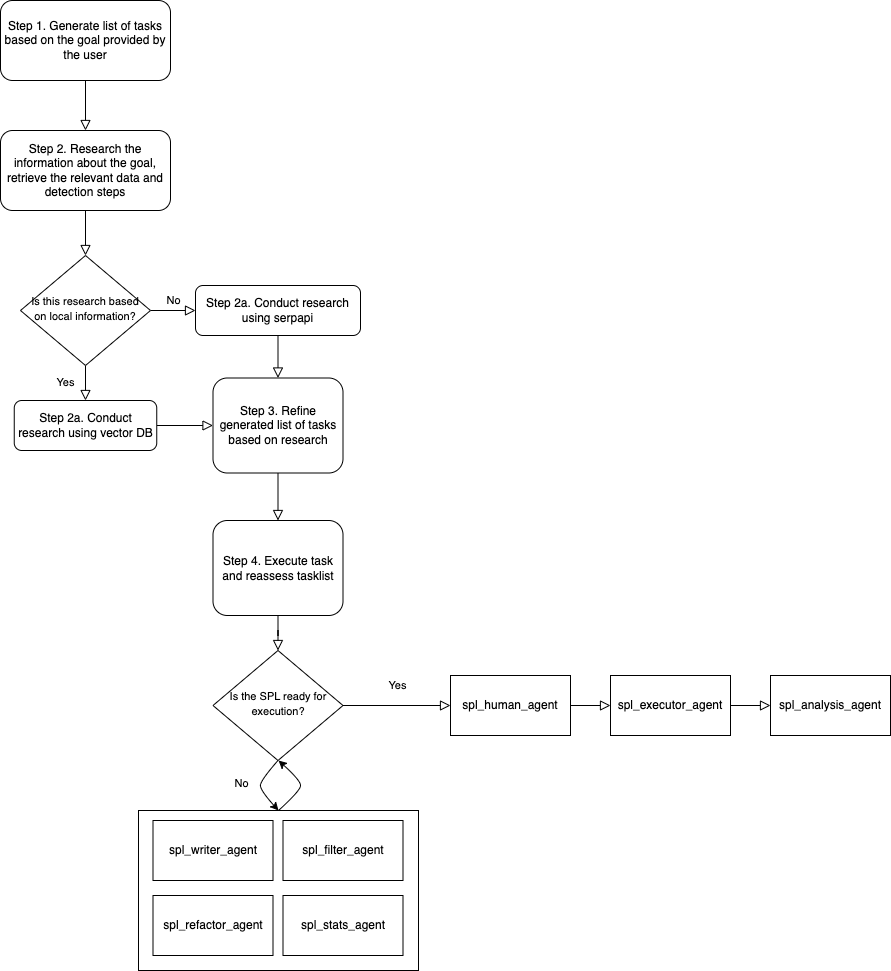

In [ ]:
# For instructional purposes, here's an example output from SplunkGPT's Plan and Solve Prompt
context_response = """
{
    "tasks": [
        {
            "id": 1,
            "description": "Write a Splunk SPL query to detect a BsidesAugusta attack. The query should include searching for Windows Event ID 7040 and 7036 in the System event logs to identify hosts with the service BsidesAugusta installed.",
            "agent": "spl_writer_agent",
            "isolated_context": "Based on the detection procedures, the Splunk SPL query should search the System event logs for Windows Event ID 7040 and 7036. These event IDs indicate changes in the start type of a Windows service and the stopped/running state of a Windows service respectively. The query should specifically look for these event IDs related to the service 'BsidesAugusta' to identify hosts with this service installed."
        },
        {
            "id": 2,
            "description": "Edit the existing SPL query to filter for relevant fields such as Windows Event ID, Field Names, and Data. This will help in narrowing down the search results and focusing on the required information.",
            "agent": "spl_filter_agent",
            "isolated_context": "Building on the previous task, the existing SPL query needs to be edited to include filters for relevant fields such as Windows Event ID, Field Names, and Data. These filters will help in narrowing down the search results and focusing only on the required information related to the BsidesAugusta attack."
        },
        {
            "id": 3,
            "description": "Refactor the existing SPL query to ensure the proper index, source, and field names are used. This will ensure that the query is executed on the correct data source and the relevant fields are considered for analysis.",
            "agent": "spl_refactor_agent",
            "isolated_context": "Continuing from the previous task, it is important to refactor the existing SPL query to include the proper index, source, and field names. This will ensure that the query is executed on the correct data source and the relevant fields are considered for analysis. The index, source, and field names should be specified based on the organization's Splunk configuration."
        },
        {
            "id": 4,
            "description": "Apply a statistical analysis of the current SPL query using SPL commands such as stats, where, or table to detect patterns indicative of a BsidesAugusta attack. This analysis will help in identifying any suspicious patterns or anomalies in the data.",
            "agent": "spl_statistical_analysis_agent",
            "isolated_context": "To detect patterns indicative of a BsidesAugusta attack, a statistical analysis needs to be applied to the current SPL query. SPL commands such as stats, where, or table can be used for this purpose. The analysis should focus on identifying any suspicious patterns or anomalies in the data that may indicate an ongoing BsidesAugusta attack."
        },
        {
            "id": 5,
            "description": "Run a Splunk SPL search using the developed SPL query to identify instances of a BsidesAugusta attack. This search will execute the query and provide results indicating any occurrences of the attack.",
            "agent": "splunk_executor_agent",
            "isolated_context": "After developing and refining the SPL query, it needs to be executed by running a Splunk SPL search. This search will execute the query and provide results indicating any occurrences of a BsidesAugusta attack. The search results will help in identifying specific instances of the attack."
        },
        {
            "id": 6,
            "description": "Analyze the results of the Splunk search to determine if a BsidesAugusta attack has occurred. This analysis will involve reviewing the search results and looking for any evidence or indicators of the attack.",
            "agent": "analysis_agent",
            "isolated_context": "Once the Splunk search is completed, the results need to be analyzed to determine if a BsidesAugusta attack has occurred. This analysis involves reviewing the search results and looking for any evidence or indicators of the attack. The analysis should consider the patterns, anomalies, and any other relevant information identified during the search."
        }
    ]
}
"""

In [ ]:
# loading task created by Plan and Solve Prompt
task_json = json.loads(context_response)
task_list_json = task_json["tasks"]

# looping through each id in the task list and determining which function to call
for task in task_list_json:
  # load each field in the JSON
  task_description = task["description"]
  task_isolated_context = task["isolated_context"]
  task_agent_reccomendation = task["agent"]
  chosen_agent = task["agent"]

  if chosen_agent == "splunk_executor_agent":
    print("splunk_executor_agent")
    while True:
      human_answer = input("Would you like to modify the final query before executing? (Yes/No): ")
      if human_answer.lower() in ["yes", "y"]:
          #human_input = input("What would you like to modify? ")
          print("What would you like to modify? \n")
          print("Remove the string spl from the first line of the query")
          # Function call to human interaction. This portion would be used to modify the final SPL query before it is ran
          """
            context_response = splunk_human_input_agent_chain.predict(
            human_input=human_input,
            query=context_response
          )
          """
          context_response = """
          index=main sourcetype="WinEventLog:System" (EventCode=7040 OR EventCode=7036) BsidesAugusta
            | fields Account_Domain, Account_Name, Additional_Information
            | stats count by Account_Domain, Account_Name, Additional_Information
            | where count > 1
          """
          print(f"Output from SPL Executer Agent:\n\n{context_response}\n\n Is it good? \n\n")
      else:
          human_input = "No updates required"
          """
          context_response = splunk_human_input_agent_chain.predict(
            human_input=human_input,
            query=context_response
          )
          """
          print(f"Output from SPL Executer Agent:\n\n{context_response}\n\nIs it good?\n\n")
          break
  else:
    # SplunkGPT Agent for building the SPL
    if chosen_agent == "spl_writer_agent":
      # create the baseline for a splunk query
      """
      context_response = spl_writer_agent_testing_chain.predict(
          objective=objective,
          task=task_description,
          isolated_context=task_isolated_context
          )
      """
      context_response = "splunk_query = index=system sourcetype=WinEventLog:System (EventCode=7040 OR EventCode=7036) BsidesAugusta"

      print(f"Output from SPL Writer Agent:\n\n{context_response}\n\n")

    elif chosen_agent == 'spl_filter_agent':
      #adjusts the query based off of the fields from the research it conducted
      """
      input_variables=["objective", "task","previous_query", "isolated_context"],
      """
      print("spl_filter_agent")

      """
      context_response = spl_filter_agent_chain.predict(
          objective=objective,
          task=task_description,
          previous_query=context_response,
          isolated_context=task_isolated_context
          )
      """
      context_response = "index=main sourcetype=\"WinEventLog:System\" (EventCode=7040 OR EventCode=7036) BsidesAugusta | fields Account_Domain, Account_Name, Additional_Information"

      print(f"Output from SPL Filter Agent:\n\n{context_response}\n\n")
    elif chosen_agent == "spl_statistical_analysis_agent":
      # applies a mathmatical analysis of the the results to help with creating a detection
      '''
      spl_statistical_analysis_agent = PromptTemplate(
      input_variables=["objective", "task","previous_query", "isolated_context"],
      '''

      print("spl_stats_agent")
      """
      context_response = spl_statistical_analysis_chain.predict(
          objective=objective,
          task=task_description,
          previous_query=context_response,
          isolated_context=task_isolated_context
      )
      """
      context_response = """
      spl
      index=main sourcetype="WinEventLog:System" (EventCode=7040 OR EventCode=7036) BsidesAugusta
      | fields Account_Domain, Account_Name, Additional_Information
      | stats count by Account_Domain, Account_Name, Additional_Information
      | where count > 1
      """
      print(f"Output from SPL Stats Agent:\n\n{context_response}\n\n")

    elif chosen_agent == "spl_refactor_agent":
      #adjusts the query based off of the fields and index names from the splunk server

      '''
      input_variables=["objective","task_description", "objective","isolated_context","existing_spl","command_execution_errors"]
      '''

      print("spl_refactor_agent")
      """
      command_execution_errors = "No Errors"
      context_response = spl_normalize_chain.predict(
          existing_spl=context_response,
          objective=objective,
          splunk_info=splunk_info,
          schema=schema
      )
      """

      context_response = """
      index=main sourcetype="WinEventLog:System" (EventCode=7040 OR EventCode=7036) BsidesAugusta
      | fields Account_Domain, Account_Name, Additional_Information
      | stats count by Account_Domain, Account_Name, Additional_Information
      | where count > 1
      """

      print(f"Output from SPL Refactor Agent:\n\n{context_response}\n\n")

print("running query \n\n")
"""
final_data = run_splunk_search(final_query)

splunk_results=[]

for item in final_data:
    #print(item)
    splunk_results.append(item)

#print(splunk_results)
summary_response = spl_summary_chain.predict(
          objective=objective,
          query=context_response,
          results=splunk_results
      )
print(summary_response)
"""
print("It appears the WIN10 host has been infected with the BsidesAugusta Supply Chain Compromise")